<a href="https://colab.research.google.com/github/Lenguist/insight-game-ai/blob/main/simple_sim_united.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description moved to readme

# q learn

In [130]:
class Episode(object):
  def __init__(self, buyer, seller, verbose=True):
    self.buyer = buyer
    self.seller = seller
    self.verbose = verbose # whether to print info

  def negotiation_round(self):
    if self.verbose:
      print(f"Curr state: {self.seller.state}")

    offer = self.seller.make_offer()
    decision = self.buyer.check_offer(offer)
    new_state = {"last-offer":offer, "offers-made":self.seller.state["offers-made"]+1}
    self.seller.update_table(offer, decision, new_state)
    self.seller.state = new_state

    if self.verbose:
      print(f"Seller made offer of {offer}. The buyer decided to {decision}")
    return decision

  def run_episode(self):
    decision = ""
    while decision != "walk away" and decision != "accept offer":
      decision = self.negotiation_round()

    if decision == "accept offer":
      final_offer = self.seller.state["last-offer"]
      profit = final_offer - self.seller.value
      if self.verbose:
        print(f"Deal made at {final_offer}")
        print(f"Buyer's max_price was {self.buyer.maxprice}")

    else:
      if self.verbose:
        print(f"No deal made - no profit.")
        print(f"Buyer's max_price was {self.buyer.maxprice}")
      profit = 0
    # reset seller state
    self.seller.reset_state()
    return profit

In [167]:
"Seller classes"
import random
import numpy as np
import math



class Seller(object):
  def __init__(self, value, init_offer):
    self.value = value
    self.init_offer = init_offer
    self.state = {"last-offer": self.init_offer, "offers-made":0} # initial state
  def make_offer(self):
    raise NotImplementedError("Subclasses should implement this method.")
  def reset_state(self):
    self.state = {"last-offer":self.init_offer, "offers-made":0}
  def update_table(self, offer, decision, new_state ):
    pass


class RandomSeller(Seller):
  def make_offer(self):
    offer = int(random.uniform(self.value+1, self.state["last-offer"])) # return random offer
    return offer

  
class DescentArithmeticSeller(Seller):
  def __init__(self, value, init_offer, init_descent):
    super().__init__(value, init_offer)
    self.init_descent = init_descent
    self.descent = init_descent
  def make_offer(self):
    offer = self.state["last-offer"]-max(self.descent,1)
    self.descent = self.descent-1
    return offer
  def reset_state(self):
    super().reset_state()
    self.descent = self.init_descent

class QLearningSeller(Seller):
  def __init__(self, value, init_offer):
    super().__init__(value, init_offer)
    action_space_size = self.init_offer - self.value
    state_space_size = (self.init_offer - self.value) ** 2
    self.q_table = np.zeros((state_space_size, action_space_size))

    # Q-Learning parameters
    self.learning_rate = 0.1
    self.discount_rate = 0.99
    self.exploration_rate = .15

    # # unused variables
    # self.max_exploration_rate = 1
    # self.min_exploration_rate = 0.01
    # self.exploration_decay_rate = 0.001

  def make_offer(self):
    random_number = random.uniform(0, 1)
    if random_number > self.exploration_rate:
      offer = np.argmax(self.q_table[self.get_state_array_number(self.state), :]) + (self.value+1)
    else: #exploring
      offer = random.randint(self.value+1,self.state['last-offer']-1)
    return offer
  
  # helper methods
  def get_state_array_number(self, state):
    return state['last-offer']-(self.value+1)+(self.init_offer-self.value)*state['offers-made']

  def from_array_num_get_state(self, array_num):
    offers_made = math.floor(array_num/(self.init_offer-self.value))
    last_offer =  array_num % (self.init_offer-self.value) + (self.value + 1)
    return {"last-offer":last_offer, "offers-made":offers_made}
  
  def update_table(self, offer, decision, new_state):
    if decision == 'accept offer':
      reward = offer - self.value
    else:
      reward = 0
    
    state_array_number = self.get_state_array_number(self.state)
    new_state_array_number = self.get_state_array_number(new_state)
    self.q_table[state_array_number, offer-(self.value+1)] = self.q_table[state_array_number, offer-(self.value+1)] * (1 - self.learning_rate) + \
                                  self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state_array_number, :]))

  def set_exploiting(self):
    self.exploration_rate = 0


In [161]:
# imp_incr constant, max_price random
def basic_simulation(value, range_min, range_max, imp_incr, rounds, seller, verbose=False):
  total_profit = 0
  for i in range(rounds):
    maxprice = int(random.uniform(range_min, range_max+1))
    buyer = Buyer(maxprice, 0, imp_incr)
    episode = Episode(buyer, seller, verbose=False)
    profit = episode.run_episode()
    total_profit += profit
  average_return = total_profit/rounds

  return average_return

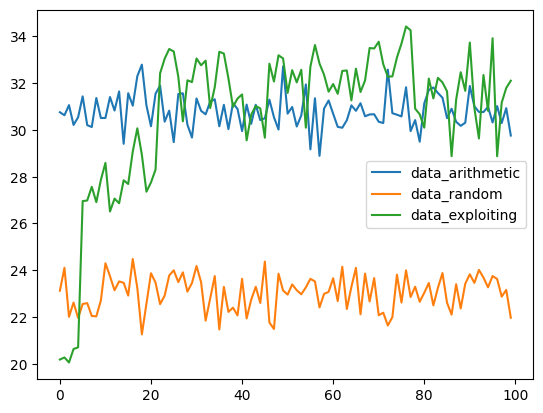

In [169]:
from buyer import Buyer
# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 100
rounds = 1000

init_offer=range_max

sellerQ = QLearningSeller(value=value, init_offer=init_offer)
sellerAri = DescentArithmeticSeller(value=value, init_offer=range_max,init_descent=(range_max-range_min)/3)
sellerRandom = RandomSeller(value=value,init_offer=init_offer)

rewards_learning = []
rewards_exploiting = []
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  0.01,
                            rounds = rounds,
                            seller=sellerQ,
                            verbose=False)
    rewards_learning.append(result)

sellerQ.set_exploiting()
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  0.01,
                            rounds = rounds,
                            seller=sellerQ,
                            verbose=False)
    rewards_exploiting.append(result)


rewards_descent_arithmetic = []
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  0.01,
                            rounds = rounds,
                            seller=sellerAri,
                            verbose=False)
    rewards_descent_arithmetic.append(result)

rewards_random = []
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  0.01,
                            rounds = rounds,
                            seller=sellerRandom,
                            verbose=False)
    rewards_random.append(result)

import matplotlib.pyplot as plt

# your data
data_arithmetic = rewards_descent_arithmetic
data_exploiting = rewards_learning
data_random = rewards_random

# create a figure and axis
fig, ax = plt.subplots()

# plot the data
ax.plot(data_arithmetic, label = 'data_arithmetic')
ax.plot(data_random, label = 'data_random')
ax.plot(data_exploiting, label = 'data_exploiting')
ax.legend()
# show the plot
plt.show()
